In [6]:
# Basic Libraries
import pandas as pd
import numpy as np
import sqlite3
import os
from pathlib import Path
data_folder = Path("C:/Amazon/")

# Feature Scaling
from sklearn.preprocessing import RobustScaler

# Classifier (machine learning algorithm) 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict

# Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
    # Continuous Data Plot
def cont_plot(df, feature_name, target_name, palettemap, hue_order, feature_scale): 
    df['Counts'] = "" # A trick to skip using an axis (either x or y) on splitting violinplot
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(20,5))
    sns.distplot(df[feature_name], ax=axis0);
    sns.violinplot(x=feature_name, y="Counts", hue=target_name, hue_order=hue_order, data=df,
                   palette=palettemap, split=True, orient='h', ax=axis1)
    axis1.set_xticks(feature_scale)
    plt.show()
    # WARNING: This will leave Counts column in dataset if you continues to use this dataset

    # Categorical/Ordinal Data Plot
def cat_plot(df, feature_name, target_name, palettemap): 
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.show()

    
survival_palette = {0: "black", 1: "orange"} # Color map for visualization

#sqlquery
conn = sqlite3.connect('C:/Amazon/Amazon.db')
c = conn.cursor()


In [ ]:

########################################  EXPLORATION  ########################################

#count distinct values,

### dim_product ###
#54, 14102, 68, 32, 5407

pd.read_sql("select count(distinct product_line_name) as product_line_name,    \
            count(distinct product_name) as product_name,    \
            count(distinct sub_product_name) as sub_product_name,    \
            count(distinct service_group_name) as service_group_name,    \
            count(distinct product_company_name) as product_company_name    \
            from dim_product"    \
            , con=conn)

### dim_territory ###
#6, 67, 6080, 6
pd.read_sql("select count(distinct region),    \
            count(distinct sub_region),    \
            count(distinct territory_code),    \
            count(distinct segment),    \
            from dim_territory"    \
            , con=conn)

############################################  END  ###########################################  


In [ ]:
#####################################  FEATURE ENGINEERING PT 1  ####################################

#create new product_sid,old sid missing 1 character (P), not able to join
pd.read_sql("create table dim_product2 as \
            select a.*,     \
                    case when substr(product_sid,1,2) = 'HS'    \
                    then 'P'||product_sid else product_sid end as product_sid2 \
            from dim_product a" , con=conn)


pd.read_sql("create table dim_account2 as \
            select a.*,     \
                    case when substr(payer_account_id,1,1) = 'A'    \
                    then 'P'||payer_account_id else payer_account_id end as payer_account_id2 \
            from dim_account a" , con=conn)

pd.read_sql("create table dim_calendar2 as \
            select month_id, calendar_date     \
            from dim_calendar a    \
            group by 1    \
            having max(calendar_date)    \
            " , con=conn)

#create new revenue table with product lines, service group
pd.read_sql("create table rev_pdt as \
            select a.*, b.product_line_name, b.sub_product_name, b.service_group_name    \
            from fact_sales_revenue a    \
            left join    \
            dim_product2 b     \
            on a.product_sid = b.product_sid2" , con=conn)


pd.read_sql("create table rev_pdt2 as \
            select a.*, b.region, b.sub_region, b.segment    \
            from rev_pdt a    \
            left join    \
            dim_territory b     \
            on a.territory_sid = b.territory_sid" , con=conn)

#This is to derive vintage/month-on-book
pd.read_sql("create table rev_pdt3 as    \
            select a.*, b.*    \
            from rev_pdt2 a    \
            left join dim_account2 b    \
            on a.payer_account_id = b.payer_account_id2    \
            ", con=conn)

pd.read_sql("CREATE UNIQUE INDEX index_name ON rev_pdt3    \
            (territory_sid, payer_account_id, product_sid, month_id)    \
            ", con=conn)

pd.read_sql("create table rev_pdt4 as    \
            select a.*, b.calendar_date,     \
            julianday(b.calendar_date) - julianday(a.payer_account_registration_date) as day_dif    \
            from rev_pdt3 a    \
            left join dim_calendar2 b    \
            on a.month_id = b.month_id", con=conn)


subpdt_plt = pd.read_sql("select sub_product_name, count(*) as obs from rev_pdt4 group by 1", con=conn)
sns.countplot(x='obs',data=subpdt_plt)


pd.read_sql("create table rev_pdt5 as    \
            select a.*,     \
                    case when payer_account_status_code= 'Suspended' then 1 else 0 end as f_ac_cd_susp,    \
                    case when payer_account_status_code= 'Active' then 1 else 0 end as f_ac_cd_actv,    \
                    case when payer_account_status_code= 'DEV_TOKEN' then 1 else 0 end as f_ac_cd_dev,    \
                    \
                    case when payer_account_role_name= 'Regular' then 1 else 0 end as f_ac_role_reg,    \
                    case when payer_account_role_name= 'Linked' then 1 else 0 end as f_ac_role_link,    \
                    case when payer_account_role_name is null then 1 else 0 end as f_ac_role_null,    \
                    \
                    case when is_payer_account_bill_in_90_days= 'Y' then 1 else 0 end as f_ac_bill90days,    \
                    case when is_payer_account_enterprise= 'Y' then 1 else 0 end as f_ac_ent,    \
                    case when is_payer_account_domain_free_domain= 'Y' then 1 else 0 end as f_ac_freedom,    \
                    case when is_payer_account_on_enterprise_support= 'Y' then 1 else 0 end as f_ac_entsupp,    \
                    case when is_payer_account_on_business_support= 'Y' then 1 else 0 end as f_ac_bizsupp,    \
                    case when is_payer_account_fraud= 'Y' then 1 else 0 end as f_ac_fraud,    \
                    case when is_payer_account_suspended= 'Y' then 1 else 0 end as f_ac_susp,    \
                    case when is_payer_account_internal= 'Y' then 1 else 0 end as f_ac_intrnl,    \
                    case when is_payer_account_inp_terminated= 'Y' then 1 else 0 end as f_ac_term,    \
                    case when is_payer_account_on_behalf_of= 'Y' then 1 else 0 end as f_ac_behalf,    \
                    case when is_payer_account_tax_exempt= 'Y' then 1 else 0 end as f_ac_tax_exempt,    \
                    case when is_payer_account_reseller= 'Y' then 1 else 0 end as f_ac_resell,    \
                    \
                    case when payer_account_status_code = 'Active' then 1 else 0 end as f_ac_active,   \
                    \
                    case when product_line_name = 'Product Line 13' then 1 else 0 end as f_pdt_13,   \
                    case when product_line_name = 'Product Line 12'then 1 else 0 end as f_pdt_12,     \
                    case when product_line_name = 'Product Line 10' then 1 else 0 end as f_pdt_10,    \
                    case when product_line_name = 'Product Line 6' then 1 else 0 end as f_pdt_6,    \
                    case when product_line_name not in ('Product Line 13','Product Line 12','Product Line 10','Product Line 6')    \
                    then 1 else 0 end as f_pdt_oth,    \
                    1 as f_pdt,    \
                    \
                    case when sub_product_name = 'Sub Product 67' then 1 else 0 end as f_subpdt_67,    \
                    case when sub_product_name = 'Sub Product 14' then 1 else 0 end as f_subpdt_14,    \
                    case when sub_product_name = 'Sub Product 13' then 1 else 0 end as f_subpdt_13,    \
                    case when sub_product_name = 'Sub Product 12' then 1 else 0 end as f_subpdt_12,    \
                    case when sub_product_name = 'Sub Product 11' then 1 else 0 end as f_subpdt_11,    \
                    case when sub_product_name = 'Sub Product 9' then 1 else 0 end as f_subpdt_9,    \
                    case when sub_product_name = 'Sub Product 2' then 1 else 0 end as f_subpdt_2,    \
                    case when sub_product_name = 'Sub Product 1' then 1 else 0 end as f_subpdt_1,    \
                    case when sub_product_name not in ('Sub Product 67','Sub Product 14','Sub Product 13','Sub Product 12','Sub Product 11','Sub Product 9','Sub Product 2','Sub Product 1')    \
                    then 1 else 0 end as f_subpdt_oth,    \
                    1 as f_subpdt,    \
                    \
                    case when service_group_name = 'Service Group 18' then 1 else 0 end as f_srvgp_18,     \
                    case when service_group_name = 'Service Group 8' then 1 else 0 end as f_srvgp_8,    \
                    case when service_group_name = 'Service Group 9' then 1 else 0 end as f_srvgp_9,     \
                    case when service_group_name = 'Service Group 16' then 1 else 0 end as f_srvgp_16,    \
                    case when service_group_name not in ('Service Group 18',	'Service Group 8',	'Service Group 9',	'Service Group 16')    \
                    then 1 else 0 end as f_srvgp_oth,    \
                    1 as f_srvgp,    \
                    \
                    case when sub_region = 'Sub Region106' then 1 else 0 end as f_subreg_106,    \
                    case when sub_region = 'Sub Region117' then 1 else 0 end as f_subreg_117,    \
                    case when sub_region = 'Sub Region173' then 1 else 0 end as f_subreg_173,    \
                    case when sub_region = 'Sub Region227' then 1 else 0 end as f_subreg_227,    \
                    case when sub_region = 'Sub Region268' then 1 else 0 end as f_subreg_268,     \
                    case when sub_region = 'Sub Region299' then 1 else 0 end as f_subreg_299,    \
                    case when sub_region = 'Sub Region338' then 1 else 0 end as f_subreg_338,    \
                    case when sub_region = 'Sub Region53' then 1 else 0 end as f_subreg_53,    \
                    case when sub_region not in ('Sub Region106',	'Sub Region117',	'Sub Region173',	'Sub Region227',	'Sub Region268',	'Sub Region299',	'Sub Region338',	'Sub Region53')    \
                    then 1 else 0 end as f_subreg_oth,    \
                    \
                    case when segment = 'APAC Segment 5' then 1 else 0 end as f_seg_5,    \
                    case when segment = 'APAC Segment 1'  then 1 else 0 end as f_seg_1,    \
                    case when segment not in ('APAC Segment 5', 'APAC Segment 1')    \
                    then 1 else 0 end as f_seg_oth    \
                    from rev_pdt4 a", con=conn)


#monthly summary,1160280
pd.read_sql("create table summ_mth as    \
            select payer_account_id,   \
            month_id,     \
            cast(substr(payer_account_first_billing_reporting_date,1,4)||substr(payer_account_first_billing_reporting_date,6,2) as int) as firstbill_month_id, \
            cast(substr(payer_account_registration_date,1,4)||substr(payer_account_registration_date,6,2) as int) as regist_month_id, \
            calendar_date,     \
            sum(sales_revenue) as sales_revenue,   \
            sum(f_ac_active) as v_ac_active,    \
            sum(f_pdt_13) as v_pdt_13,    \
            sum(f_pdt_12) as v_pdt_12,    \
            sum(f_pdt_10) as v_pdt_10,    \
            sum(f_pdt_6) as v_pdt_6,    \
            sum(f_pdt_oth) as v_pdt_oth,    \
            sum(f_pdt) as v_pdt,    \
            sum(f_subpdt_67) as v_subpdt_67,    \
            sum(f_subpdt_14) as v_subpdt_14,    \
            sum(f_subpdt_13) as v_subpdt_13,    \
            sum(f_subpdt_12) as v_subpdt_12,    \
            sum(f_subpdt_11) as v_subpdt_11,    \
            sum(f_subpdt_9) as v_subpdt_9,    \
            sum(f_subpdt_2) as v_subpdt_2,    \
            sum(f_subpdt_1) as v_subpdt_1,    \
            sum(f_subpdt_oth) as v_subpdt_oth,    \
            sum(f_subpdt) as v_subpdt,    \
            sum(f_srvgp_18) as v_srvgp_18,    \
            sum(f_srvgp_8) as v_srvgp_8,    \
            sum(f_srvgp_9) as v_srvgp_9,    \
            sum(f_srvgp_16) as v_srvgp_16,    \
            sum(f_srvgp_oth) as v_srvgp_oth,    \
            sum(f_srvgp) as v_srvgp,    \
            sum(f_subreg_106) as v_subreg_106,    \
            sum(f_subreg_117) as v_subreg_117,    \
            sum(f_subreg_173) as v_subreg_173,    \
            sum(f_subreg_227) as v_subreg_227,    \
            sum(f_subreg_268) as v_subreg_268,    \
            sum(f_subreg_299) as v_subreg_299,    \
            sum(f_subreg_338) as v_subreg_338,    \
            sum(f_subreg_53) as v_subreg_53,    \
            sum(f_subreg_oth) as v_subreg_oth,    \
            sum(f_seg_5) as v_seg_5,    \
            sum(f_seg_1) as v_seg_1,    \
            sum(f_seg_oth) as v_seg_oth,    \
            case when sum(f_ac_active) >= 1 then 1 else 0 end as f_ac_active,    \
            case when sum(f_pdt_13) >= 1 then 1 else 0 end as f_pdt_13,    \
            case when sum(f_pdt_12) >= 1 then 1 else 0 end as f_pdt_12,    \
            case when sum(f_pdt_10) >= 1 then 1 else 0 end as f_pdt_10,    \
            case when sum(f_pdt_6) >= 1 then 1 else 0 end as f_pdt_6,    \
            case when sum(f_pdt_oth) >= 1 then 1 else 0 end as f_pdt_oth,    \
            case when sum(f_pdt) >= 1 then 1 else 0 end as f_pdt,    \
            case when sum(f_subpdt_67) >= 1 then 1 else 0 end as f_subpdt_67,    \
            case when sum(f_subpdt_14) >= 1 then 1 else 0 end as f_subpdt_14,    \
            case when sum(f_subpdt_13) >= 1 then 1 else 0 end as f_subpdt_13,    \
            case when sum(f_subpdt_12) >= 1 then 1 else 0 end as f_subpdt_12,    \
            case when sum(f_subpdt_11) >= 1 then 1 else 0 end as f_subpdt_11,    \
            case when sum(f_subpdt_9) >= 1 then 1 else 0 end as f_subpdt_9,    \
            case when sum(f_subpdt_2) >= 1 then 1 else 0 end as f_subpdt_2,    \
            case when sum(f_subpdt_1) >= 1 then 1 else 0 end as f_subpdt_1,    \
            case when sum(f_subpdt_oth) >= 1 then 1 else 0 end as f_subpdt_oth,    \
            case when sum(f_subpdt) >= 1 then 1 else 0 end as f_subpdt,    \
            case when sum(f_srvgp_18) >= 1 then 1 else 0 end as f_srvgp_18,    \
            case when sum(f_srvgp_8) >= 1 then 1 else 0 end as f_srvgp_8,    \
            case when sum(f_srvgp_9) >= 1 then 1 else 0 end as f_srvgp_9,    \
            case when sum(f_srvgp_16) >= 1 then 1 else 0 end as f_srvgp_16,    \
            case when sum(f_srvgp_oth) >= 1 then 1 else 0 end as f_srvgp_oth,    \
            case when sum(f_subreg_106) >= 1 then 1 else 0 end as f_subreg_106,    \
            case when sum(f_subreg_117) >= 1 then 1 else 0 end as f_subreg_117,    \
            case when sum(f_subreg_173) >= 1 then 1 else 0 end as f_subreg_173,    \
            case when sum(f_subreg_227) >= 1 then 1 else 0 end as f_subreg_227,    \
            case when sum(f_subreg_268) >= 1 then 1 else 0 end as f_subreg_268,    \
            case when sum(f_subreg_299) >= 1 then 1 else 0 end as f_subreg_299,    \
            case when sum(f_subreg_338) >= 1 then 1 else 0 end as f_subreg_338,    \
            case when sum(f_subreg_53) >= 1 then 1 else 0 end as f_subreg_53,    \
            case when sum(f_subreg_oth) >= 1 then 1 else 0 end as f_subreg_oth,    \
            case when sum(f_seg_5) >= 1 then 1 else 0 end as f_seg_5,    \
            case when sum(f_seg_1) >= 1 then 1 else 0 end as f_seg_1,     \
            case when sum(f_seg_oth) >= 1 then 1 else 0 end as f_seg_oth    \
            from rev_pdt5     \
            group by 1, 2, 3, 4 , 5", con=conn)

# more features, create account flags
pd.read_sql("create table flags as    \
            select payer_account_id,   \
            month_id,     \
            max(day_dif) as day_dif,    \
            max(f_ac_bill90days) as f_ac_bill90days,    \
            max(f_ac_ent) as f_ac_ent,    \
            max(f_ac_freedom) as f_ac_freedom,    \
            max(f_ac_entsupp) as f_ac_entsupp,    \
            max(f_ac_bizsupp) as f_ac_bizsupp,    \
            max(f_ac_fraud) as f_ac_fraud,    \
            max(f_ac_susp) as f_ac_susp,    \
            max(f_ac_intrnl) as f_ac_intrnl,    \
            max(f_ac_term) as f_ac_term,    \
            max(f_ac_behalf) as f_ac_behalf,    \
            max(f_ac_tax_exempt) as f_ac_tax_exempt,    \
            max(f_ac_resell) as f_ac_resell    \
            from rev_pdt5     \
            group by 1, 2", con=conn)

pd.read_sql("create table summ_mth2 as    \
            select a.*, b.*   \
            from summ_mth a    \
            left join flags b    \
            on a.payer_account_id = b.payer_account_id    \
            and a.month_id = b.month_id", con=conn)
            
#get 201512, 201612, 201712 baseline
df = pd.read_sql(" \
            select payer_account_id,    \
            case when sum(f_201512) >= 1 then 1 else 0 end as f_201512,    \
            case when sum(f_201612) >= 1 then 1 else 0 end as f_201612,    \
            case when sum(f_201712) >= 1 then 1 else 0 end as f_201712,    \
            sum(rev_201512) as rev_201512,    \
            sum(rev_201612) as rev_201612,    \
            sum(rev_201712) as rev_201712    \
            from   \
            (select payer_account_id, \
            month_id,    \
            count(*) as obs,    \
            case when month_id = 201512 then count(*) else 0 end as f_201512,    \
            case when month_id = 201612 then count(*) else 0 end as f_201612,    \
            case when month_id = 201712 then count(*) else 0 end as f_201712,    \
            case when month_id = 201512 then sum(sales_revenue) else 0 end as rev_201512,    \
            case when month_id = 201612 then sum(sales_revenue) else 0 end as rev_201612,    \
            case when month_id = 201712 then sum(sales_revenue) else 0 end as rev_201712    \
            from summ_mth2  \
            where month_id in (201512,201612,201712) group by 1,2)    \
            group by 1    \
            ", con=conn)     
            
df.to_sql(name='placeholder', con=conn)

#create churn
pd.read_sql("create table summ_mth3 as    \
            select a.*,     \
            b.f_201512,    \
            b.f_201612,    \
            b.f_201712,    \
            b.rev_201512,    \
            b.rev_201612,    \
            b.rev_201712,    \
            case when substr(a.month_id,1,4) = '2015' then 0 \
                 when substr(a.month_id,1,4) = '2016' and (f_201512 = 1 and rev_201512 >1 and (sales_revenue <1 or sales_revenue is null)) then 1\
                 when substr(a.month_id,1,4) = '2017' and (f_201612 = 1 and rev_201612 >1 and (sales_revenue <1 or sales_revenue is null)) then 1\
                 when substr(a.month_id,1,4) = '2018' and (f_201712 = 1 and rev_201712 >1 and (sales_revenue <1 or sales_revenue is null)) then 1\
                 else 0 end as f_churn,    \
            case when substr(a.month_id,1,4) = '2015' then 0 \
                 when substr(a.month_id,1,4) = '2016' and (f_201512 = 1 and rev_201512 >1) then 1\
                 when substr(a.month_id,1,4) = '2017' and (f_201612 = 1 and rev_201612 >1) then 1\
                 when substr(a.month_id,1,4) = '2018' and (f_201712 = 1 and rev_201712 >1) then 1\
                 else 0 end as f_baseline    \
            from summ_mth2  a    \
            left join placeholder b   \
            on a.payer_account_id = b.payer_account_id    \
            ", con=conn)
############################################  END  ###########################################  

In [3]:
#check churn and baseline variables
pd.read_sql("select payer_account_id,\
            sales_revenue,    \
            month_id,   \
            rev_201512,    \
            rev_201612,    \
            rev_201712,    \
            f_baseline,    \
            f_churn    \
            from summ_mth3    \
            where f_baseline = 1 and f_churn = 1    \
            limit 5", con=conn)

,payer_account_id,sales_revenue,month_id,rev_201512,rev_201612,rev_201712,f_baseline,f_churn
0,PA000000000000010212,0.40,201802,0.00,0.00,3.000000,1,1
1,PA000000000000014643,-1.75,201804,0.00,0.00,1.730000,1,1
2,PA000000000000020089,0.32,201609,9.19,8.17,0.000000,1,1
3,PA000000000000020480,0.92,201612,1.51,0.92,0.000000,1,1
4,PA000000000000021674,0.48,201703,17.01,4.22,0.479999,1,1


In [30]:
#####################################  FEATURE ENGINEERING PT 2  ####################################
#yearly summary
pd.read_sql("create table summ_yr as    \
            select payer_account_id,   \
            substr(month_id,1,4) as year,     \
            sum(sales_revenue) as sales_revenue_yr,   \
            sum(f_ac_active) as v_ac_active_yr,    \
            sum(f_pdt_13) as v_pdt_13_yr,    \
            sum(f_pdt_12) as v_pdt_12_yr,    \
            sum(f_pdt_10) as v_pdt_10_yr,    \
            sum(f_pdt_6) as v_pdt_6_yr,    \
            sum(f_pdt_oth) as v_pdt_oth_yr,    \
            sum(f_pdt) as v_pdt_yr,    \
            sum(f_subpdt_67) as v_subpdt_67_yr,    \
            sum(f_subpdt_14) as v_subpdt_14_yr,    \
            sum(f_subpdt_13) as v_subpdt_13_yr,    \
            sum(f_subpdt_12) as v_subpdt_12_yr,    \
            sum(f_subpdt_11) as v_subpdt_11_yr,    \
            sum(f_subpdt_9) as v_subpdt_9_yr,    \
            sum(f_subpdt_2) as v_subpdt_2_yr,    \
            sum(f_subpdt_1) as v_subpdt_1_yr,    \
            sum(f_subpdt_oth) as v_subpdt_oth_yr,    \
            sum(f_subpdt) as v_subpdt_yr,    \
            sum(f_srvgp_18) as v_srvgp_18_yr,    \
            sum(f_srvgp_8) as v_srvgp_8_yr,    \
            sum(f_srvgp_9) as v_srvgp_9_yr,    \
            sum(f_srvgp_16) as v_srvgp_16_yr,    \
            sum(f_srvgp_oth) as v_srvgp_oth_yr,    \
            sum(f_subreg_106) as v_subreg_106_yr,    \
            sum(f_subreg_117) as v_subreg_117_yr,    \
            sum(f_subreg_173) as v_subreg_173_yr,    \
            sum(f_subreg_227) as v_subreg_227_yr,    \
            sum(f_subreg_268) as v_subreg_268_yr,    \
            sum(f_subreg_299) as v_subreg_299_yr,    \
            sum(f_subreg_338) as v_subreg_338_yr,    \
            sum(f_subreg_53) as v_subreg_53_yr,    \
            sum(f_subreg_oth) as v_subreg_oth_yr,    \
            sum(f_seg_5) as v_seg_5_yr,    \
            sum(f_seg_1) as v_seg_1_yr,    \
            sum(f_seg_oth) as v_seg_oth_yr,    \
            case when sum(f_ac_active) >= 1 then 1 else 0 end as f_ac_active_yr,    \
            case when sum(f_pdt_13) >= 1 then 1 else 0 end as f_pdt_13_yr,    \
            case when sum(f_pdt_12) >= 1 then 1 else 0 end as f_pdt_12_yr,    \
            case when sum(f_pdt_10) >= 1 then 1 else 0 end as f_pdt_10_yr,    \
            case when sum(f_pdt_6) >= 1 then 1 else 0 end as f_pdt_6_yr,    \
            case when sum(f_pdt_oth) >= 1 then 1 else 0 end as f_pdt_oth,    \
            case when sum(f_pdt) >= 1 then 1 else 0 end as f_pdt_yr,    \
            case when sum(f_subpdt_67) >= 1 then 1 else 0 end as f_subpdt_67_yr,    \
            case when sum(f_subpdt_14) >= 1 then 1 else 0 end as f_subpdt_14_yr,    \
            case when sum(f_subpdt_13) >= 1 then 1 else 0 end as f_subpdt_13_yr,    \
            case when sum(f_subpdt_12) >= 1 then 1 else 0 end as f_subpdt_12_yr,    \
            case when sum(f_subpdt_11) >= 1 then 1 else 0 end as f_subpdt_11_yr,    \
            case when sum(f_subpdt_9) >= 1 then 1 else 0 end as f_subpdt_9_yr,    \
            case when sum(f_subpdt_2) >= 1 then 1 else 0 end as f_subpdt_2_yr,    \
            case when sum(f_subpdt_1) >= 1 then 1 else 0 end as f_subpdt_1_yr,    \
            case when sum(f_subpdt_oth) >= 1 then 1 else 0 end as f_subpdt_oth_yr,    \
            case when sum(f_subpdt) >= 1 then 1 else 0 end as f_subpdt,    \
            case when sum(f_srvgp_18) >= 1 then 1 else 0 end as f_srvgp_18_yr,    \
            case when sum(f_srvgp_8) >= 1 then 1 else 0 end as f_srvgp_8_yr,    \
            case when sum(f_srvgp_9) >= 1 then 1 else 0 end as f_srvgp_9_yr,    \
            case when sum(f_srvgp_16) >= 1 then 1 else 0 end as f_srvgp_16_yr,    \
            case when sum(f_srvgp_oth) >= 1 then 1 else 0 end as f_srvgp_oth_yr,    \
            case when sum(f_subreg_106) >= 1 then 1 else 0 end as f_subreg_106_yr,    \
            case when sum(f_subreg_117) >= 1 then 1 else 0 end as f_subreg_117_yr,    \
            case when sum(f_subreg_173) >= 1 then 1 else 0 end as f_subreg_173_yr,    \
            case when sum(f_subreg_227) >= 1 then 1 else 0 end as f_subreg_227_yr,    \
            case when sum(f_subreg_268) >= 1 then 1 else 0 end as f_subreg_268_yr,    \
            case when sum(f_subreg_299) >= 1 then 1 else 0 end as f_subreg_299_yr,    \
            case when sum(f_subreg_338) >= 1 then 1 else 0 end as f_subreg_338_yr,    \
            case when sum(f_subreg_53) >= 1 then 1 else 0 end as f_subreg_53_yr,    \
            case when sum(f_subreg_oth) >= 1 then 1 else 0 end as f_subreg_oth_yr,    \
            case when sum(f_seg_5) >= 1 then 1 else 0 end as f_seg_5_yr,    \
            case when sum(f_seg_1) >= 1 then 1 else 0 end as f_seg_1_yr,     \
            case when sum(f_seg_oth) >= 1 then 1 else 0 end as f_seg_oth_yr    \
            from summ_mth3     \
            group by 1, 2", con=conn)

###quarterly summary
pd.read_sql("create table summ_qtr as    \
            select payer_account_id,  \
            case when substr(month_id,5,2) in ('01','02','03') then cast(substr(month_id,1,4)||'03' as int)   \
                 when substr(month_id,5,2) in ('04','05','06') then cast(substr(month_id,1,4)||'06' as int)    \
                 when substr(month_id,5,2) in ('07','08','09') then cast(substr(month_id,1,4)||'09' as int)    \
                 when substr(month_id,5,2) in ('10','11','12') then cast(substr(month_id,1,4)||'12' as int)    \
                 end as quarters,\
            sum(sales_revenue) as sales_revenue_qtr,   \
            sum(f_ac_active) as v_ac_active_qtr,    \
            sum(f_pdt_13) as v_pdt_13_qtr,    \
            sum(f_pdt_12) as v_pdt_12_qtr,    \
            sum(f_pdt_10) as v_pdt_10_qtr,    \
            sum(f_pdt_6) as v_pdt_6_qtr,    \
            sum(f_pdt_oth) as v_pdt_oth_qtr,    \
            sum(f_pdt) as v_pdt_qtr,    \
            sum(f_subpdt_67) as v_subpdt_67_qtr,    \
            sum(f_subpdt_14) as v_subpdt_14_qtr,    \
            sum(f_subpdt_13) as v_subpdt_13_qtr,    \
            sum(f_subpdt_12) as v_subpdt_12_qtr,    \
            sum(f_subpdt_11) as v_subpdt_11_qtr,    \
            sum(f_subpdt_9) as v_subpdt_9_qtr,    \
            sum(f_subpdt_2) as v_subpdt_2_qtr,    \
            sum(f_subpdt_1) as v_subpdt_1_qtr,    \
            sum(f_subpdt_oth) as v_subpdt_oth_qtr,    \
            sum(f_subpdt) as v_subpdt_qtr,    \
            sum(f_srvgp_18) as v_srvgp_18_qtr,    \
            sum(f_srvgp_8) as v_srvgp_8_qtr,    \
            sum(f_srvgp_9) as v_srvgp_9_qtr,    \
            sum(f_srvgp_16) as v_srvgp_16_qtr,    \
            sum(f_srvgp_oth) as v_srvgp_oth_qtr,    \
            sum(f_subreg_106) as v_subreg_106_qtr,    \
            sum(f_subreg_117) as v_subreg_117_qtr,    \
            sum(f_subreg_173) as v_subreg_173_qtr,    \
            sum(f_subreg_227) as v_subreg_227_qtr,    \
            sum(f_subreg_268) as v_subreg_268_qtr,    \
            sum(f_subreg_299) as v_subreg_299_qtr,    \
            sum(f_subreg_338) as v_subreg_338_qtr,    \
            sum(f_subreg_53) as v_subreg_53_qtr,    \
            sum(f_subreg_oth) as v_subreg_oth_qtr,    \
            sum(f_seg_5) as v_seg_5_qtr,    \
            sum(f_seg_1) as v_seg_1_qtr,    \
            sum(f_seg_oth) as v_seg_oth_qtr,    \
            case when sum(f_ac_active) >= 1 then 1 else 0 end as f_ac_active_qtr,    \
            case when sum(f_pdt_13) >= 1 then 1 else 0 end as f_pdt_13_qtr,    \
            case when sum(f_pdt_12) >= 1 then 1 else 0 end as f_pdt_12_qtr,    \
            case when sum(f_pdt_10) >= 1 then 1 else 0 end as f_pdt_10_qtr,    \
            case when sum(f_pdt_6) >= 1 then 1 else 0 end as f_pdt_6_qtr,    \
            case when sum(f_pdt_oth) >= 1 then 1 else 0 end as f_pdt_oth,    \
            case when sum(f_pdt) >= 1 then 1 else 0 end as f_pdt_qtr,    \
            case when sum(f_subpdt_67) >= 1 then 1 else 0 end as f_subpdt_67_qtr,    \
            case when sum(f_subpdt_14) >= 1 then 1 else 0 end as f_subpdt_14_qtr,    \
            case when sum(f_subpdt_13) >= 1 then 1 else 0 end as f_subpdt_13_qtr,    \
            case when sum(f_subpdt_12) >= 1 then 1 else 0 end as f_subpdt_12_qtr,    \
            case when sum(f_subpdt_11) >= 1 then 1 else 0 end as f_subpdt_11_qtr,    \
            case when sum(f_subpdt_9) >= 1 then 1 else 0 end as f_subpdt_9_qtr,    \
            case when sum(f_subpdt_2) >= 1 then 1 else 0 end as f_subpdt_2_qtr,    \
            case when sum(f_subpdt_1) >= 1 then 1 else 0 end as f_subpdt_1_qtr,    \
            case when sum(f_subpdt_oth) >= 1 then 1 else 0 end as f_subpdt_oth_qtr,    \
            case when sum(f_subpdt) >= 1 then 1 else 0 end as f_subpdt,    \
            case when sum(f_srvgp_18) >= 1 then 1 else 0 end as f_srvgp_18_qtr,    \
            case when sum(f_srvgp_8) >= 1 then 1 else 0 end as f_srvgp_8_qtr,    \
            case when sum(f_srvgp_9) >= 1 then 1 else 0 end as f_srvgp_9_qtr,    \
            case when sum(f_srvgp_16) >= 1 then 1 else 0 end as f_srvgp_16_qtr,    \
            case when sum(f_srvgp_oth) >= 1 then 1 else 0 end as f_srvgp_oth_qtr,    \
            case when sum(f_subreg_106) >= 1 then 1 else 0 end as f_subreg_106_qtr,    \
            case when sum(f_subreg_117) >= 1 then 1 else 0 end as f_subreg_117_qtr,    \
            case when sum(f_subreg_173) >= 1 then 1 else 0 end as f_subreg_173_qtr,    \
            case when sum(f_subreg_227) >= 1 then 1 else 0 end as f_subreg_227_qtr,    \
            case when sum(f_subreg_268) >= 1 then 1 else 0 end as f_subreg_268_qtr,    \
            case when sum(f_subreg_299) >= 1 then 1 else 0 end as f_subreg_299_qtr,    \
            case when sum(f_subreg_338) >= 1 then 1 else 0 end as f_subreg_338_qtr,    \
            case when sum(f_subreg_53) >= 1 then 1 else 0 end as f_subreg_53_qtr,    \
            case when sum(f_subreg_oth) >= 1 then 1 else 0 end as f_subreg_oth_qtr,    \
            case when sum(f_seg_5) >= 1 then 1 else 0 end as f_seg_5_qtr,    \
            case when sum(f_seg_1) >= 1 then 1 else 0 end as f_seg_1_qtr,     \
            case when sum(f_seg_oth) >= 1 then 1 else 0 end as f_seg_oth_qtr    \
            from summ_mth3     \
            group by 1, 2", con=conn)

## create vintage/mob variable
month = pd.read_sql("select payer_account_id, firstbill_month_id, regist_month_id,month_id, sales_revenue from summ_mth3", con=conn)
month['firstbill_date_id'] = pd.to_datetime(month['firstbill_month_id'], format='%Y%m', errors='coerce').dropna()
month['regis_date_id'] = pd.to_datetime(month['regist_month_id'], format='%Y%m', errors='coerce').dropna()
month['date_id'] = pd.to_datetime(month['month_id'], format='%Y%m', errors='coerce').dropna()
month['date_l12m'] = pd.to_datetime(month['month_id'], format='%Y%m', errors='coerce').dropna() - pd.Timedelta(days=365) 
month['month_id_l12m']=pd.to_datetime(month['date_l12m'], format='%Y%m', errors='coerce').dt.strftime('%Y%m').astype(int)
month['firstbill_day_dif'] = (month["date_id"] - month["regis_date_id"]).dt.days
month['regis_day_dif'] = (month["date_id"] - month["firstbill_date_id"]).dt.days

new_df=month[['payer_account_id','month_id','sales_revenue']]
new_df.rename(columns={'month_id':'month_id_l12m'},inplace=True)
new_df = pd.merge(month,month[['payer_account_id','month_id','sales_revenue']],  how='left', left_on=['payer_account_id','month_id_l12m'],right_on=['payer_account_id','month_id'])
new_df.to_sql(name='placeholder2', con=conn)
 
pd.read_sql("create table summ_mth4 as    \
            select a.*,     \
            b.month_id_l12m, b.date_l12m, b.regis_day_dif, b.firstbill_day_dif  \
            from summ_mth3  a    \
            left join placeholder2 b   \
            on a.payer_account_id = b.payer_account_id    \
            and a.month_id = b.month_id_x    \
            group by 1, 2", con=conn)


#rolling sum
def pct_change (df,key,window):
    for i in varlist:
        df[i+'_'+str(window)+'pct']=  np.where(df[key]!=df[key].shift(window), 0, abs(df[i]/df[i].shift(window)-1))

#rolling sum year, % change YoY
year = pd.read_sql("select * from summ_yr", con=conn)
varlist = ["v_pdt_13_yr",	"v_pdt_12_yr",	"v_pdt_10_yr",	"v_pdt_6_yr",	"v_pdt_oth_yr",	"v_pdt_yr",	"v_subpdt_67_yr",	"v_subpdt_14_yr",	"v_subpdt_13_yr",	"v_subpdt_12_yr",	"v_subpdt_11_yr",	"v_subpdt_9_yr",	"v_subpdt_2_yr",	"v_subpdt_1_yr",	"v_subpdt_oth_yr",	"v_subpdt_yr",	"v_srvgp_18_yr",	"v_srvgp_8_yr",	"v_srvgp_9_yr",	"v_srvgp_16_yr",	"v_srvgp_oth_yr","sales_revenue_yr"]
pct_change(year,'payer_account_id',1)
year.replace(np.inf, 0).to_sql(name='final_year', con=conn)

#rolling sum qtr, % change QoQ
qtr =  pd.read_sql("select * from summ_qtr", con=conn)
varlist = ["v_pdt_13_qtr",	"v_pdt_12_qtr",	"v_pdt_10_qtr",	"v_pdt_6_qtr",	"v_pdt_oth_qtr",	"v_pdt_qtr",	"v_subpdt_67_qtr",	"v_subpdt_14_qtr",	"v_subpdt_13_qtr",	"v_subpdt_12_qtr",	"v_subpdt_11_qtr",	"v_subpdt_9_qtr",	"v_subpdt_2_qtr",	"v_subpdt_1_qtr",	"v_subpdt_oth_qtr",	"v_subpdt_qtr",	"v_srvgp_18_qtr",	"v_srvgp_8_qtr",	"v_srvgp_9_qtr",	"v_srvgp_16_qtr",	"v_srvgp_oth_qtr","sales_revenue_qtr"]
pct_change(qtr,'payer_account_id',1)
qtr.replace(np.inf, 0).to_sql(name='final_qtr', con=conn)

#final mthly dataset
pd.read_sql("create table summ_mth5 as    \
            select a.*,     \
            b.v_pdt_13_yr_1pct,     \
            b.v_pdt_12_yr_1pct,     \
            b.v_pdt_10_yr_1pct,     \
            b.v_pdt_6_yr_1pct,     \
            b.v_pdt_oth_yr_1pct,     \
            b.v_pdt_yr_1pct,     \
            b.v_subpdt_67_yr_1pct,     \
            b.v_subpdt_14_yr_1pct,     \
            b.v_subpdt_13_yr_1pct,     \
            b.v_subpdt_12_yr_1pct,     \
            b.v_subpdt_11_yr_1pct,     \
            b.v_subpdt_9_yr_1pct,     \
            b.v_subpdt_2_yr_1pct,     \
            b.v_subpdt_1_yr_1pct,     \
            b.v_subpdt_oth_yr_1pct,     \
            b.v_subpdt_yr_1pct,     \
            b.v_srvgp_18_yr_1pct,     \
            b.v_srvgp_8_yr_1pct,     \
            b.v_srvgp_9_yr_1pct,     \
            b.v_srvgp_16_yr_1pct,     \
            b.v_srvgp_oth_yr_1pct,     \
            b.sales_revenue_yr_1pct,     \
            \
            c.v_pdt_13_qtr_1pct,     \
            c.v_pdt_12_qtr_1pct,     \
            c.v_pdt_10_qtr_1pct,     \
            c.v_pdt_6_qtr_1pct,     \
            c.v_pdt_oth_qtr_1pct,     \
            c.v_pdt_qtr_1pct,     \
            c.v_subpdt_67_qtr_1pct,     \
            c.v_subpdt_14_qtr_1pct,     \
            c.v_subpdt_13_qtr_1pct,     \
            c.v_subpdt_12_qtr_1pct,     \
            c.v_subpdt_11_qtr_1pct,     \
            c.v_subpdt_9_qtr_1pct,     \
            c.v_subpdt_2_qtr_1pct,     \
            c.v_subpdt_1_qtr_1pct,     \
            c.v_subpdt_oth_qtr_1pct,     \
            c.v_subpdt_qtr_1pct,     \
            c.v_srvgp_18_qtr_1pct,     \
            c.v_srvgp_8_qtr_1pct,     \
            c.v_srvgp_9_qtr_1pct,     \
            c.v_srvgp_16_qtr_1pct,     \
            c.v_srvgp_oth_qtr_1pct     \
            \
            from summ_mth4  a    \
            \
            left join final_year b   \
            on a.payer_account_id = b.payer_account_id    \
            and substr(a.month_id,1,6) = cast(b.year||'12' as int)    \
            \
            left join final_qtr c   \
            on a.payer_account_id = c.payer_account_id    \
            and substr(a.month_id,1,6) = c.quarters    \
            ", con=conn)

pd.read_sql("select * from summ_mth5    \
            where f_baseline = 1 and f_churn = 1    \
            limit 5", con=conn)

############################################  END  ########################################### 

,payer_account_id,month_id,firstbill_month_id,regist_month_id,calendar_date,sales_revenue,v_ac_active,v_pdt_13,v_pdt_12,v_pdt_10,...,v_subpdt_9_qtr_1pct,v_subpdt_2_qtr_1pct,v_subpdt_1_qtr_1pct,v_subpdt_oth_qtr_1pct,v_subpdt_qtr_1pct,v_srvgp_18_qtr_1pct,v_srvgp_8_qtr_1pct,v_srvgp_9_qtr_1pct,v_srvgp_16_qtr_1pct,v_srvgp_oth_qtr_1pct
0,PA000000000000010212,201802,201610,201303,2018-02-28,0.40,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,PA000000000000014643,201804,201611,201505,2018-04-30,-1.75,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,PA000000000000020089,201609,201010,201010,2016-09-30,0.32,0,7,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None
3,PA000000000000020480,201612,201111,201110,2016-12-31,0.92,0,0,0,1,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,None,0.0,None
4,PA000000000000021674,201703,201403,201403,2017-03-31,0.48,1,0,0,0,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,None,NaN,None


In [31]:
#################################  Explanatory Variable Analysis  ##################################### 

#monthly dataset to approximate baseline and churn
monthly =  pd.read_sql("select *     \
                      from summ_mth5    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      ", con=conn)
#upload for dashboard QV visualization
monthly.replace(np.inf, 0).to_sql(name='qv_mthly', con=conn)

#create separate dataset for explanatory variables, choose only latest record from each customer
varsel =  pd.read_sql("select *     \
                      from summ_mth5    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      group by payer_account_id    \
                      having max(month_id)    \
                      ", con=conn)

varsel = varsel.fillna(0)


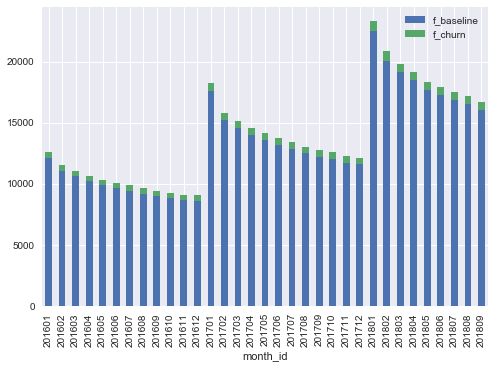

In [27]:
visual_mth = monthly[['f_baseline','f_churn']].groupby(monthly['month_id']).sum()
visual_mth.plot.bar(stacked=True)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


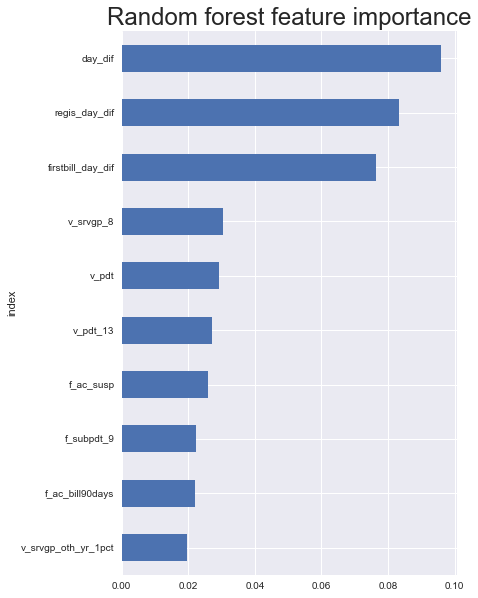

In [24]:
#drop redundant variables, partition into predictor and prediction vars
X_train = varsel.drop(["f_churn","rev_201712","rev_201612","rev_201512","sales_revenue","v_ac_active","payer_account_id",	"month_id",	"firstbill_month_id",	"regist_month_id",	"calendar_date",	"payer_account_id:1",	"month_id:1","month_id_l12m","f_201512","f_201612","f_201712",'date_l12m','sales_revenue_yr_1pct'], axis=1)
y_train = varsel['f_churn'] 

#variable importance
rforest_checker = RandomForestClassifier(random_state = 0)
rforest_checker.fit(X_train, y_train)
importances_df = pd.DataFrame(rforest_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
importances_df.reset_index(inplace=True)

# Plot the relative importance of the top 10 features
df_ = importances_df[0:10]
df_.sort_values('Feature_Importance', ascending = True, inplace = True)
df_.plot(kind='barh', x='index', y='Feature_Importance', legend=False, figsize=(6, 10))
plt.title('Random forest feature importance', fontsize = 24)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


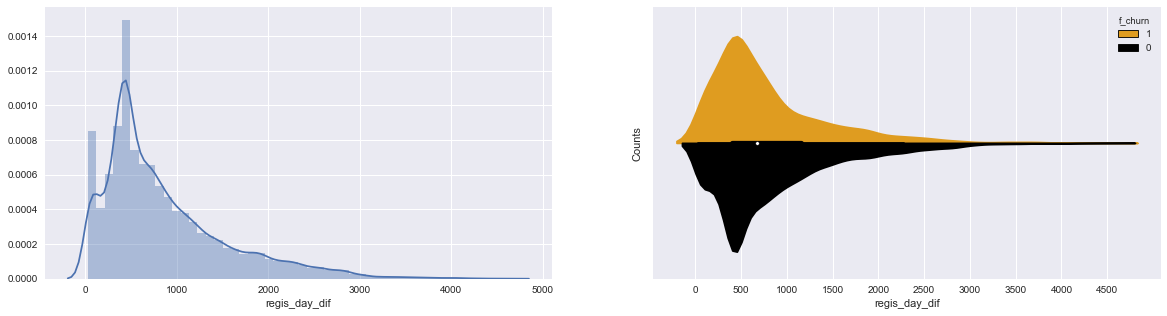

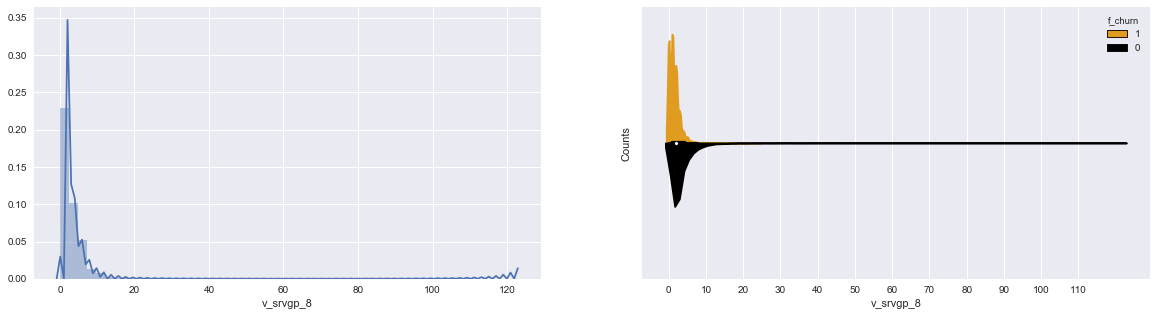

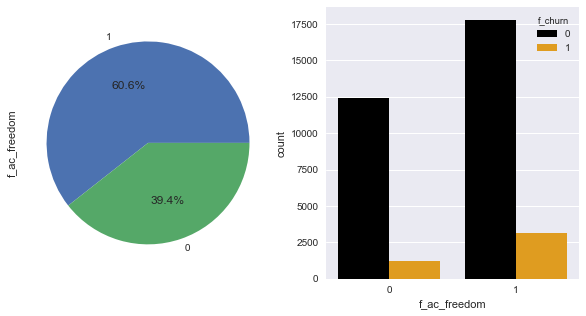

In [28]:
#see relation of variables to churn
cont_plot(varsel, 'regis_day_dif', 'f_churn', survival_palette, [1, 0], range(0,5000,500))
cont_plot(varsel, 'v_srvgp_8', 'f_churn', survival_palette, [1, 0], range(0,120,10))
cat_plot(varsel, 'f_ac_freedom', 'f_churn', survival_palette)

In [32]:
#training to see how well the factors allow us to explain churn
X_train = varsel[list(importances_df['index'].values)]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train ,test_size=0.3, random_state=0)

rforest_checker = RandomForestClassifier(n_estimators = 30, 
                              random_state = 2017, 
                              oob_score = True, 
                              max_features = 126,
                              min_samples_leaf = 8)

rforest_checker.fit(X_train, y_train)

from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
y_pred = rforest_checker.predict(X_test)
print(len(X_test))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

10366
0.899189658499
0.7336523126
[[8861  167]
 [ 878  460]]
